In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE SINAIS COMPLEXOS ---
np.random.seed(42)
n_samples = 5000
order = 4  # M=4 (5 coeficientes)

# Entrada: Ruído branco complexo
x = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)

# Planta Desconhecida (Complexa)
w_true = np.array([0.6 + 0.2j, -0.4 + 0.5j, 0.2 - 0.3j, 0.5 + 0.4j, -0.2 + 0.2j])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.02 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO SIGN-DATA LMS ---
# O step_size geralmente precisa ser menor do que no LMS padrão 
# porque o vetor de direção (sign(x)) tem norma maior/mais constante.
filt_sd = pdf.SignData(
    filter_order=order,
    step_size=0.005
)

result = filt_sd.optimize(x, d, verbose=True)

[SignData] Completed in 16.299 ms


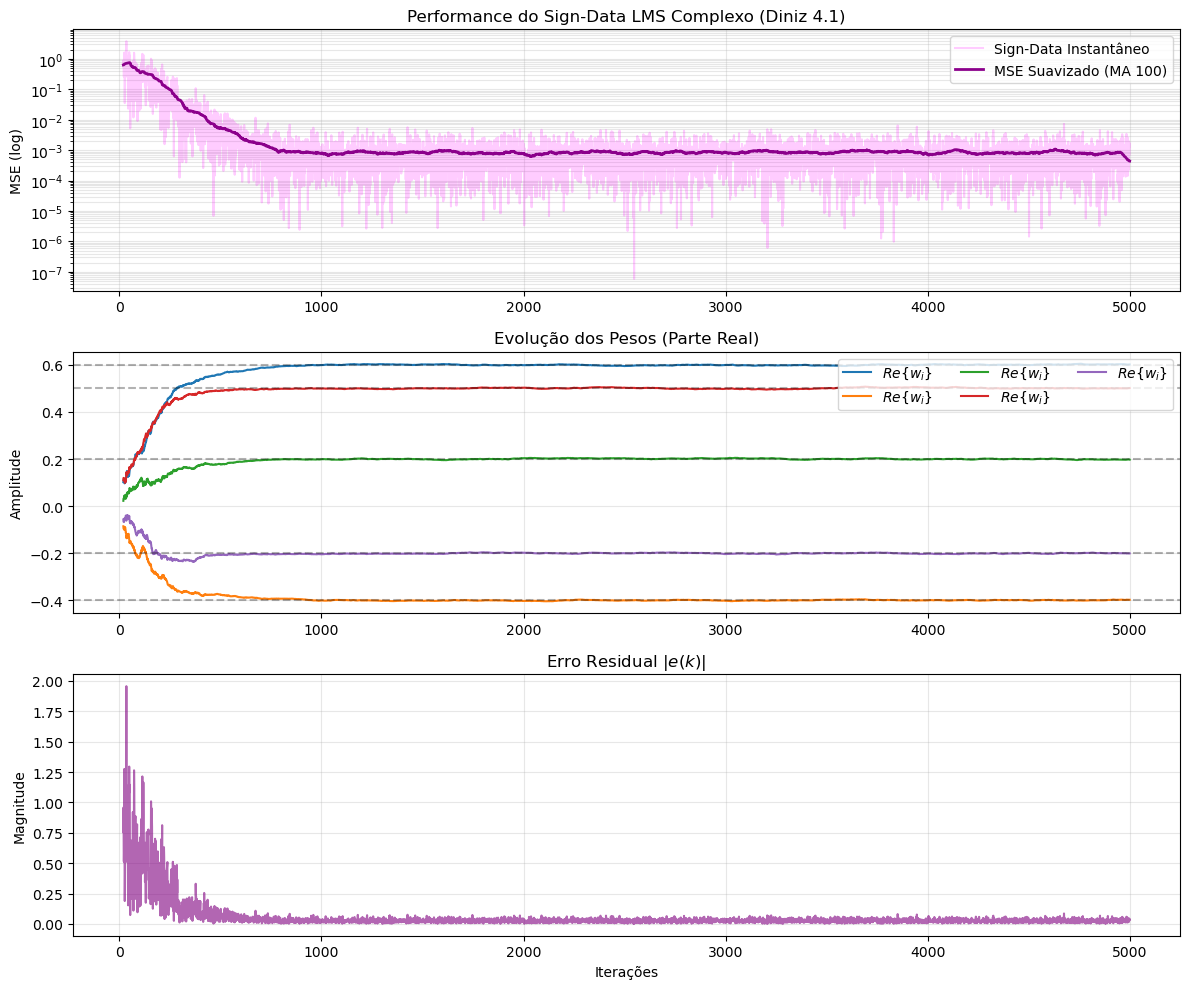

In [3]:
# --- 3. ANÁLISE VISUAL ---
offset = 20
mse = result.mse()
t = np.arange(len(mse))

# Ajuste do histórico (removendo w_init)
coeffs_history = result.coefficients
if coeffs_history.shape[0] > len(mse):
    coeffs_history = coeffs_history[1:]

plt.figure(figsize=(12, 10))

# Subplot 1: MSE
plt.subplot(3, 1, 1)
plt.semilogy(t[offset:], mse[offset:], label='Sign-Data Instantâneo', alpha=0.2, color='magenta')
mse_smooth = np.convolve(mse, np.ones(100)/100, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Suavizado (MA 100)', color='darkmagenta', lw=2)
plt.title('Performance do Sign-Data LMS Complexo (Diniz 4.1)')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes (Parte Real)
plt.subplot(3, 1, 2)
coeffs_real = np.real(coeffs_history)
for i in range(coeffs_real.shape[1]):
    plt.plot(t[offset:], coeffs_real[offset:, i], label=r'$Re\{{w_{i}\}}$')
    plt.axhline(y=np.real(w_true[i]), color='black', linestyle='--', alpha=0.3)
plt.title('Evolução dos Pesos (Parte Real)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Magnitude do Erro Residual
plt.subplot(3, 1, 3)
plt.plot(t[offset:], np.abs(result.errors[offset:]), color='purple', alpha=0.6)
plt.title('Erro Residual $|e(k)|$')
plt.xlabel('Iterações')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()